# Defining variability and smoothness with the covariance function

In [1]:
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm

from bo import ackley, forrester_1d, visualize_gp_belief

In [2]:
class ScaleGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
xs = torch.linspace(-3, 3, 101).unsqueeze(1)
ys = forrester_1d(xs)

torch.manual_seed(0)
train_x = torch.rand(size=(3, 1)) * 6 - 3
train_y = forrester_1d(train_x)

In [4]:
import ipywidgets as widgets
from ipywidgets import interact


@interact(
    lengthscale=widgets.Dropdown(options=[0.3, 1, 3], value=1),
    outputscale=widgets.Dropdown(options=[0.3, 1, 3], value=3),
)
def f(lengthscale, outputscale):
    noise = 1e-4
    likelihood = gpytorch.likelihoods.GaussianLikelihood()

    model = ScaleGPModel(train_x, train_y, likelihood)
    model.covar_module.base_kernel.lengthscale = lengthscale
    model.covar_module.outputscale = outputscale
    model.likelihood.noise = noise

    model.eval()
    likelihood.eval()

    visualize_gp_belief(
        model, likelihood, xs=xs, ys=ys, train_x=train_x, train_y=train_y
    )

interactive(children=(Dropdown(description='lengthscale', index=1, options=(0.3, 1, 3), value=1), Dropdown(des…

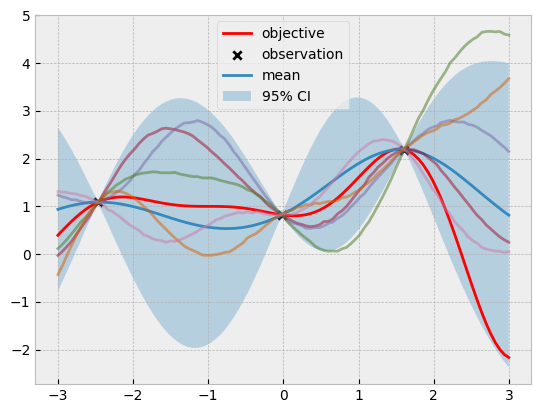

In [5]:
noise = 1e-4
lengthscale = 1
outputscale = 3

likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = ScaleGPModel(train_x, train_y, likelihood)
model.covar_module.base_kernel.lengthscale = lengthscale
model.covar_module.outputscale = outputscale
model.likelihood.noise = noise

model.eval()
likelihood.eval()
visualize_gp_belief(model, likelihood, xs=xs, ys=ys, train_x=train_x, train_y=train_y)

In [6]:
# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.covar_module.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
lengthscales = []
outputscales = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()

    losses.append(loss.item())
    lengthscales.append(model.covar_module.base_kernel.lengthscale.item())
    outputscales.append(model.covar_module.outputscale.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

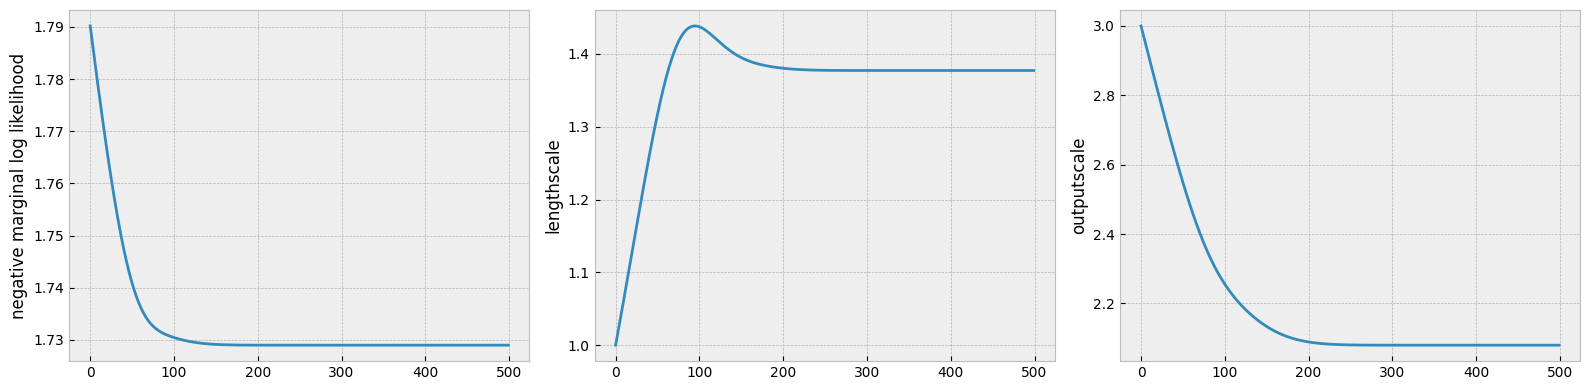

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(lengthscales)
ax[1].set_ylabel("lengthscale")

ax[2].plot(outputscales)
ax[2].set_ylabel("outputscale")

plt.tight_layout();

In [8]:
(
    model.covar_module.base_kernel.lengthscale.item(),
    model.covar_module.outputscale.item(),
)

(1.37723708152771, 2.079803705215454)

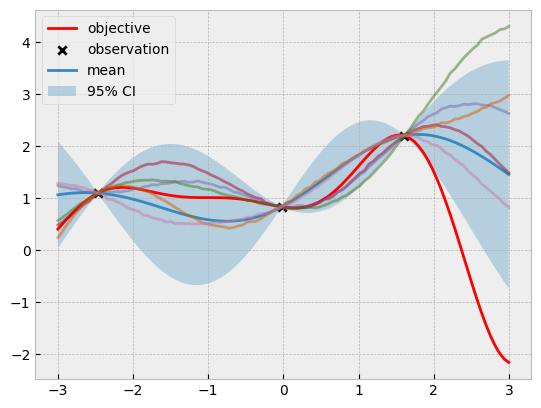

In [9]:
visualize_gp_belief(model, likelihood, xs=xs, ys=ys, train_x=train_x, train_y=train_y)

## Controlling smoothness with different covariance functions

In [10]:
class MaternGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, nu):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.MaternKernel(nu)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [11]:
lengthscale = 1
noise = 1e-4


@interact(nu=widgets.Dropdown(options=[1 / 2, 3 / 2, 5 / 2], value=5 / 2))
def update(nu):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = MaternGPModel(train_x, train_y, likelihood, nu)
    model.covar_module.lengthscale = lengthscale
    model.likelihood.noise = noise

    model.eval()
    likelihood.eval()

    visualize_gp_belief(
        model, likelihood, xs=xs, ys=ys, train_x=train_x, train_y=train_y
    )

interactive(children=(Dropdown(description='nu', index=2, options=(0.5, 1.5, 2.5), value=2.5), Output()), _dom…

## Modelling different levels of variability with multiple length scales

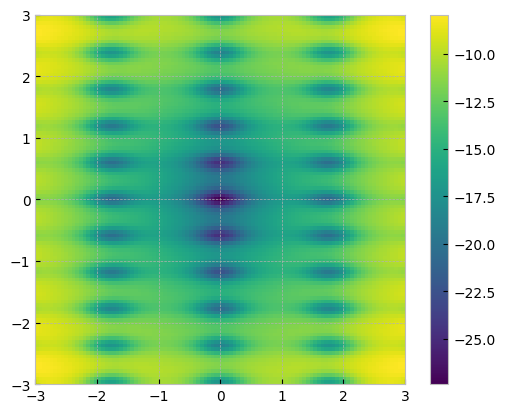

In [12]:
xs = torch.linspace(-5, 5, 101)
x1, x2 = torch.meshgrid(xs, xs, indexing="ij")
xs = torch.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)
ys = ackley(xs)

plt.imshow(ys.reshape(101, 101).T, origin="lower", extent=[-3, 3, -3, 3])
plt.colorbar();

In [13]:
torch.manual_seed(0)
train_x = torch.rand(size=(100, 2)) * 6 - 3
train_y = ackley(train_x)

In [14]:
class ARDGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            # Num dims must match the objective function dimensions.
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [15]:
noise = 1e-4
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ARDGPModel(train_x, train_y, likelihood)

# fix the hyperparameters.
model.likelihood.noise = noise

# train the hyperparameter (the constant)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
x_lengthscales = []
y_lengthscales = []
outputscales = []
for i in tqdm(range(500)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()

    losses.append(loss.item())
    x_lengthscales.append(model.covar_module.base_kernel.lengthscale[0, 0].item())
    y_lengthscales.append(model.covar_module.base_kernel.lengthscale[0, 1].item())
    outputscales.append(model.covar_module.outputscale.item())

    optimizer.step()

model.eval()
likelihood.eval()

  0%|          | 0/500 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

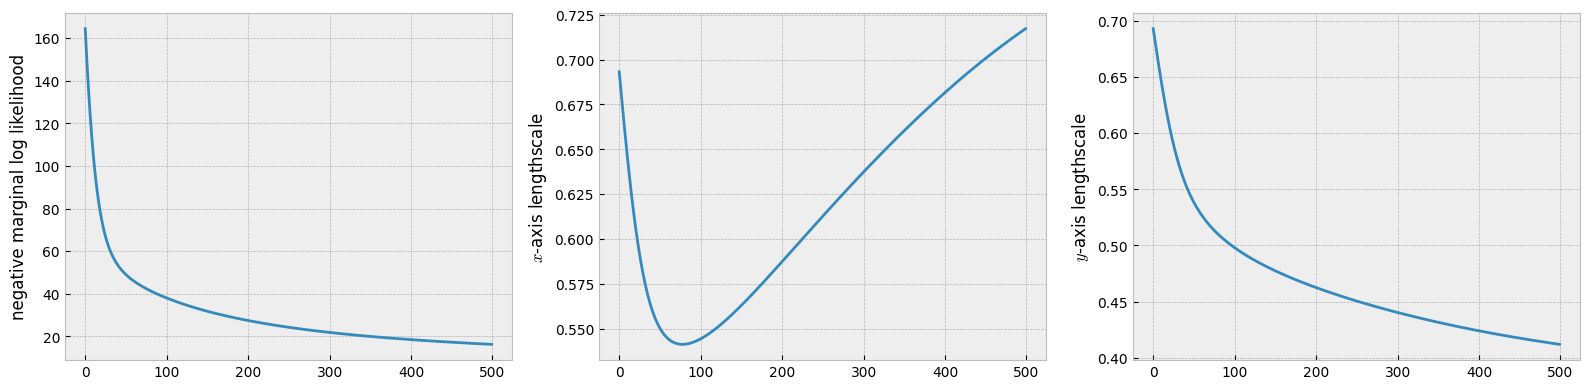

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ax[0].plot(losses)
ax[0].set_ylabel("negative marginal log likelihood")

ax[1].plot(x_lengthscales)
ax[1].set_ylabel(r"$x$-axis lengthscale")

ax[2].plot(y_lengthscales)
ax[2].set_ylabel(r"$y$-axis lengthscale")

plt.tight_layout();

In [17]:
model.covar_module.base_kernel.lengthscale

tensor([[0.7176, 0.4117]], grad_fn=<SoftplusBackward0>)